In [27]:
import numpy as np
import math
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, execute, Aer
from qiskit import ClassicalRegister, QuantumRegister, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.compiler import transpile, assemble
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Importing functions to run on real device
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-18 12:54:36,939: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# define functions first
# adopted from:
# https://medium.com/@sashwat.anagolum/arithmetic-on-quantum-computers-multiplication-4482cdc2d83b

def createInputState(qc, reg, n, pie):
    """
    Apply one Hadamard gate to the nth qubit of the quantum register               
    reg, and then apply repeated phase rotations with parameters  
    being pi divided by increasing powers of two.
    """
    qc.h(reg[n])    
    for i in range(0, n):
        qc.cu1(pie/float(2**(i+1)), reg[n-(i+1)], reg[n])

In [4]:
        
def evolveQFTState(qc, reg_a, reg_b, n, pie):
    """
    Evolves the state |F(ψ(reg_a))> to |F(ψ(reg_a+reg_b))> using the     
    quantum Fourier transform conditioned on the qubits of reg_b.
    Apply repeated phase rotations with parameters being pi divided 
    by increasing powers of two.
    """
    for i in range(0, n+1):
        qc.cu1(pie/float(2**(i)), reg_b[n-i], reg_a[n])
    

In [5]:
def inverseQFT(qc, reg, n, pie):
    """
    Performs the inverse quantum Fourier transform on a register 
    reg. Apply repeated phase rotations with parameters being pi    
    divided by decreasing powers of two, and then apply a Hadamard 
    gate to the nth qubit of the register reg.
    """
    for i in range(0, n):
        qc.cu1(-1*pie/float(2**(n-i)), reg[i], reg[n])
    qc.h(reg[n]) 
   

In [6]:
#Take two numbers as user input in binary form   
first = input("Enter a number with less than 10 digits.")
second = input("Enter another number with less than 10 digits.")

l1 = len(first)
l2 = len(second)
# Making sure that 'first' and 'second' are of the same length 
# by padding the smaller string with zeros
if l2>l1:
    first,second = second, first
    l2, l1 = l1, l2
second = ("0")*(l1-l2) + second

Enter a number with less than 10 digits.01
Enter another number with less than 10 digits.01


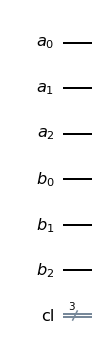

In [7]:
# determine n - length of the digits
n = max(l1,l2)
#print(l1,l2,n)
pie = math.pi    
 
# prepare 2 quantum registers based on the digit length   
a = QuantumRegister(n+1, "a") #Holds the first number
b = QuantumRegister(n+1, "b") #Holds the second number    

# We then create a classical register cl to hold the final output 
cl = ClassicalRegister(n+1, "cl") #Holds the final output

# and put all of the registers together in a quantum circuit qc:
qc = QuantumCircuit(a, b, cl, name="qc")

# SIZE OF THE CIRCUIT IS:
# 2*(n+1) of qubits and n+1 of classical registers

qc.draw("mpl")

#Now we have to store the two numbers in the registers a and b:

In [8]:
# Flip the corresponding qubit in register a if a bit in the 
# string first is a 1
for i in range(0, n):
#        print("bits in first number",first[i])     # for debugging only
        if first[i] == "1":
            qc.x(a[n-(i+1)])    
            
# Flip the corresponding qubit in register b if a bit in the 
# string second is a 1

for i in range(0, n):
#        print("bits in second number",second[i])    # for debugging only
        if second[i] == "1":
            qc.x(b[n-(i+1)])
 

<ipython-input-3-5ed3a8cae651>:13: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pie/float(2**(i+1)), reg[n-(i+1)], reg[n])


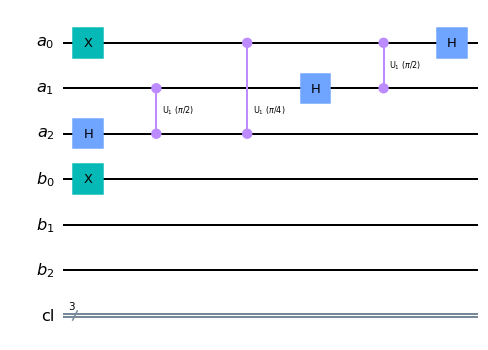

In [9]:
           
# Compute the Fourier transform of register a
for i in range(0, n+1):
        createInputState(qc, a, n-i, pie)    #Add the two numbers by evolving the Fourier transform  

qc.draw()      

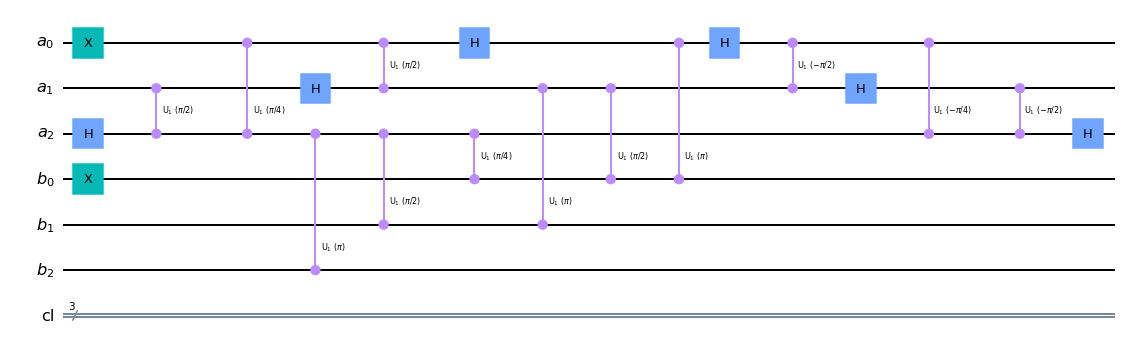

In [10]:
#F(ψ(reg_a)) >to |F(ψ(reg_a+reg_b))>
for i in range(0, n+1):
        evolveQFTState(qc, a, b, n-i, pie)    #Compute the inverse Fourier transform of register a
for i in range(0, n+1):
        inverseQFT(qc, a, i, pie)

qc.draw("mpl")

In [11]:
for i in range(0, n+1):
        qc.measure(a[i], cl[i])

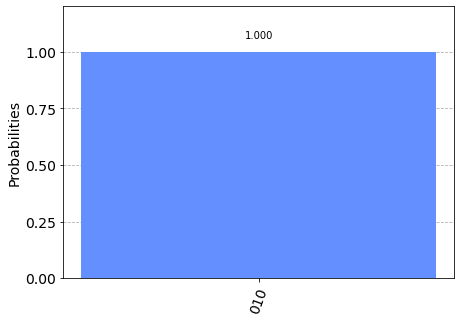

In [12]:
# let's run it now on the QASM simulator

qasm_sim = Aer.get_backend('qasm_simulator')
add_circuit = transpile(qc, qasm_sim)
qobj = assemble(add_circuit)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)        

In [13]:
# let's run it now on the QASM simulator
# but let's introduce ERRORs
# BASED ON: https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

# note: this shows summary of all available QCs (including IBM, and amount of qbits.):
# https://en.wikipedia.org/wiki/List_of_quantum_processors
# needed to select 

from qiskit.test.mock import FakeMelbourne
from qiskit.test.mock import FakeRueschlikon
device_backend_fm = FakeMelbourne()
device_backend_fr = FakeRueschlikon()

In [14]:
# list of all fake providers
# https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/test/mock/fake_provider.py

In [19]:
# let's check properties of same QCs and qubit number
from qiskit.test.mock import FakeProvider
from qiskit.test.mock import * 

x = FakeProvider()
x.backends()


for val in x.backends():
    device_backend = val
    config = device_backend.configuration() 
#     print(config.backend_name)
#     print(config.n_qubits)
    print()
    print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's'))


This backend is called fake_qasm_simulator, and is on version 0.0.0. It has 5 qubits.

This backend is called fake_openpulse_2q, and is on version 0.0.0. It has 2 qubits.

This backend is called fake_openpulse_3q, and is on version 0.0.0. It has 3 qubits.

This backend is called fake_armonk, and is on version 2.4.3. It has 1 qubit.

This backend is called fake_yorktown, and is on version 2.3.3. It has 5 qubits.

This backend is called fake_tenerife, and is on version 0.0.0. It has 5 qubits.

This backend is called fake_ourense, and is on version 1.3.5. It has 5 qubits.

This backend is called fake_vigo, and is on version 1.3.6. It has 5 qubits.

This backend is called fake_valencia, and is on version 1.4.6. It has 5 qubits.

This backend is called fake_essex, and is on version 1.0.2. It has 5 qubits.

This backend is called fake_london, and is on version 1.1.3. It has 5 qubits.

This backend is called fake_burlington, and is on version 1.1.4. It has 5 qubits.

This backend is called f

In [17]:

# FakeTokyo,  FakeAlmaden, FakeJohannesburg, FakeSingapore, FakeBoeblingen - 20 qubits
# FakeCambridge  28 qubits 
# Fake Paris, Montreals, Toronto, Sydney, Mumbai have 27 qubits
# FakeRochester 53 qubits !
# FakeManhattan 65 qubits !

In [20]:
# let's run simulation on 2 backends
# first display their properties again:

device_backend1 = FakeMelbourne()
config = device_backend1.configuration()
# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))


device_backend2 = FakeManhattan()
config = device_backend2.configuration()
# Basic Features
print("\nThis backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates))

This backend is called fake_melbourne, and is on version 0.0.0. It has 14 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['u1', 'u2', 'u3', 'cx', 'id'].

This backend is called fake_manhattan, and is on version 1.13.4. It has 65 qubits. It supports OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].


In [22]:
sim_melbourne = AerSimulator.from_backend(device_backend1)
sim_manhattan = AerSimulator.from_backend(device_backend2)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067353 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067403 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067553 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

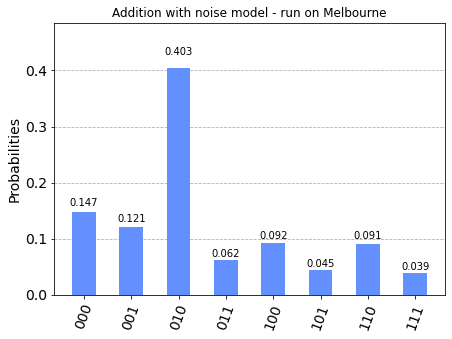

In [24]:
# Transpile the circuit for the noisy basis gates
noisy_add_circuit1 = transpile(qc, sim_melbourne)

# Execute noisy simulation and get counts on 2 different emulated noisy QCs
result_noise1 = sim_melbourne.run(noisy_add_circuit1).result()
counts_noise1 = result_noise1.get_counts(0)
plot_histogram(counts_noise1,
               title="Addition with noise model - run on Melbourne")

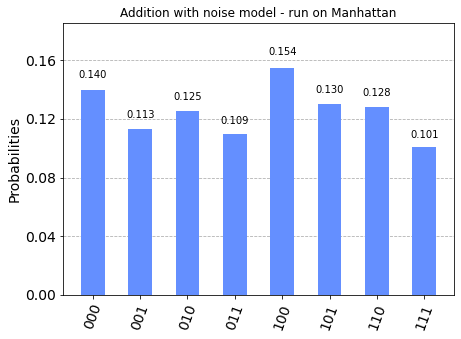

In [25]:
# Transpile the circuit for the noisy basis gates
noisy_add_circuit2 = transpile(qc, sim_manhattan)

# Execute noisy simulation and get counts on 2 different emulated noisy QCs
result_noise2 = sim_manhattan.run(noisy_add_circuit2).result()
counts_noise2 = result_noise2.get_counts(0)
plot_histogram(counts_noise2,
               title="Addition with noise model - run on Manhattan")

## Let run the same on the real QC

In [28]:
# let's run the same on the real quantum computer
# number of qubits needed:
m = (n +1)*2

# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= m and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", backend)

ibmqfactory.load_account:WARNING:2021-04-18 12:54:44,572: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_16_melbourne


In [31]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_add_circuit = transpile(qc, backend, optimization_level=3)

In [ ]:
# Create a Quantum Program for execution
job_real_qc = execute(transpiled_add_circuit, backend)
job_monitor(job_real_qc, interval=2)

Job Status: job is queued (None)  

In [ ]:
# Get the results from the computation
results = job_real_qc.result()
answer = results.get_counts(qc)
plot_histogram(answer) 